# Clasificación de imagenes para la detección del uso de tapabocas 


## Librerias

In [ ]:
#@title Carga DRIVE
import os
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
#@title Importa Librerias
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import LabelEncoder
from keras.optimizers import SGD
from collections import Counter

from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA

from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import *

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
%cd /content/drive/My Drive/Materias/2020-1/IA_I/ProyectoFinal

/content/drive/My Drive/Materias/2020-1/IA_I/ProyectoFinal


# Datos

##Face Mask Detection Dataset
Dataset [público](https://www.kaggle.com/wobotintelligence/face-mask-detection-dataset/notebooks)

In [ ]:
#@title 1. Carga rutas de datos y CSV de train
#@markdown Este dataset cuenta con un total de 4326 imagenes y 15412 etiquetas
 
#Cargo la ruta con las imagenes y las anotaciones
images=os.path.join("data/710024_1246711_bundle_archive/Data/images")
annotations=os.path.join("data/710024_1246711_bundle_archive/Data/annotations")

#Cargo los .csv para submission y train
train=pd.read_csv("data/710024_1246711_bundle_archive/train.csv")

print("Total de etiquetas:",train.shape[0])
print("Total de imagenes:",len(train["name"].unique()))
print("Clases etiquetadas:",train.classname.unique())

train.head()

Total de etiquetas: 15412
Total de imagenes: 4326
Clases etiquetadas: ['face_with_mask' 'mask_colorful' 'face_no_mask'
 'face_with_mask_incorrect' 'mask_surgical' 'face_other_covering'
 'scarf_bandana' 'eyeglasses' 'helmet' 'face_shield' 'sunglasses' 'hood'
 'hat' 'goggles' 'hair_net' 'hijab_niqab' 'other' 'gas_mask'
 'balaclava_ski_mask' 'turban']


name   x1   x2   y1   y2       classname
0  2756.png   69  126  294  392  face_with_mask
1  2756.png  505   10  723  283  face_with_mask
2  2756.png   75  252  264  390   mask_colorful
3  2756.png  521  136  711  277   mask_colorful
4  6098.jpg  360   85  728  653    face_no_mask

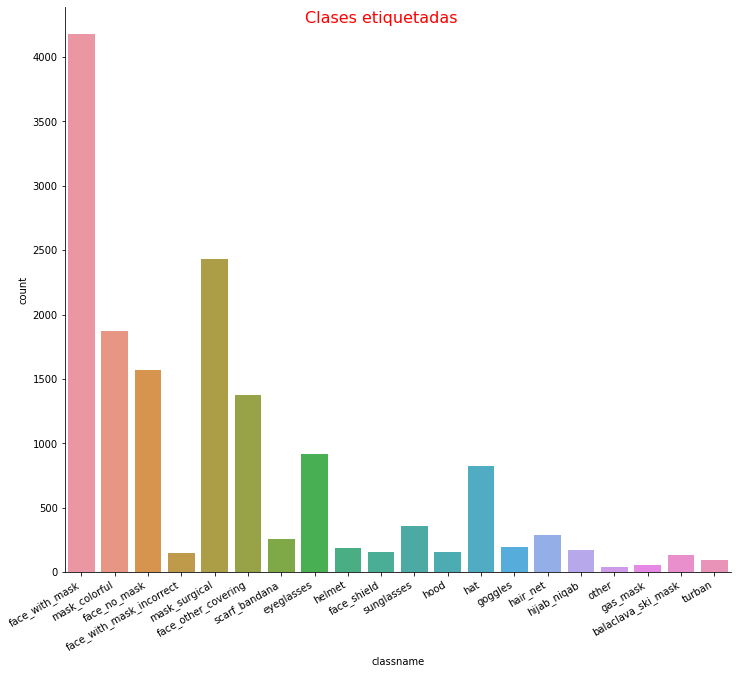

In [ ]:
#@title 2. Histograma de la diferentes clases etiquetadas
#@markdown Las etiquetas están distribuidas así:
ax = sns.catplot(x='classname',kind='count',data=train,orient="h",height=10,aspect=1)
ax.fig.suptitle('Clases etiquetadas',fontsize=16,color="r")
ax.fig.autofmt_xdate()

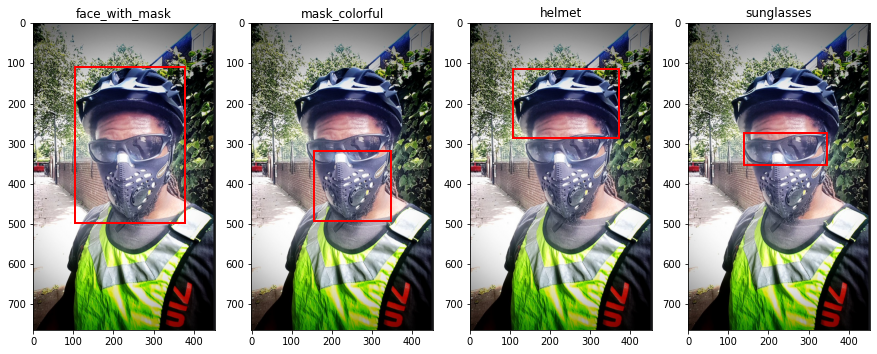

In [ ]:
#@title 3. Ejemplo anotaciones en las imagenes
#@markdown Una imagene puede tener una o varias etiquetas como lo muestra el siguiente ejemplo, donde se presentan etiquetas como:
#@markdown - face_with_mask
#@markdown - mask_colorful
#@markdown - helmet
#@markdown - sunglasses
def img_reg(id):
    train_name=train["name"][id]
    classname=train[train["name"]==train_name]["classname"]
    reg=train[train["name"]==train_name][["x1","x2","y1","y2"]]
    x1=reg["x1"][id]
    x2=reg["x2"][id]
    y1=reg["y1"][id]
    y2=reg["y2"][id]
    classname=classname[id]
    img=plt.imread(os.path.join(images,train_name))
    return x1,x2,y1,y2,classname,img
 
 
# Create suubplot
fig,[ax1,ax2,ax3,ax4] = plt.subplots(nrows=1, ncols=4, figsize=(15,15))
 
x1,x2,y1,y2,classname,img=img_reg(1002)
ax1.imshow(img)
rect1 = patches.Rectangle((x1,x2),y1-x1,y2-x2,linewidth=2,edgecolor='r',facecolor='none')
ax1.set_title(classname)
 
x1,x2,y1,y2,classname,img=img_reg(1003)
ax2.imshow(img)
rect2 = patches.Rectangle((x1,x2),y1-x1,y2-x2,linewidth=2,edgecolor='r',facecolor='none')
ax2.set_title(classname)
 
x1,x2,y1,y2,classname,img=img_reg(1004)
ax3.imshow(img)
rect3 = patches.Rectangle((x1,x2),y1-x1,y2-x2,linewidth=2,edgecolor='r',facecolor='none')
ax3.set_title(classname)
 
x1,x2,y1,y2,classname,img=img_reg(1005)
ax4.imshow(img)
rect4 = patches.Rectangle((x1,x2),y1-x1,y2-x2,linewidth=2,edgecolor='r',facecolor='none')
ax4.set_title(classname)
 
# Add the patch
ax1.add_patch(rect1)
ax2.add_patch(rect2)
ax3.add_patch(rect3)
ax4.add_patch(rect4)
 
plt.show()

## Carga datos

In [ ]:
#@title 4. Filtrado clases face_with_mask y face_no_mask
#@markdown Para nuestro proyecto se busca hacer una clasificación de imagenes de personas con tapabocas y sin tapabocas. Es por esto que se hace un filtrado de clases.

#@markdown Del DataFrame train.csv se filtran solo las filas con etiquetas de face_with_mask y face_no_mask. Luego del filtrado se ordenan con un sort_values respecto a 'name'

## Escogemos solo las clases de ['face_with_mask','face_no_mask']

clases=['face_with_mask','face_no_mask']
train=train[train.classname.isin(clases)]

#Ordenamos el dataset de acuerdo a la columna name
train.sort_values('name',axis=0,inplace=True)
print(train.shape)
train.head()

(5749, 6)


name   x1   x2   y1   y2       classname
13381  1801.jpg  451  186  895  697    face_no_mask
3463   1802.jpg  110   71  273  272  face_with_mask
14835  1803.jpg  126   75  303  333  face_with_mask
5867   1804.jpg  112  113  262  307  face_with_mask
6194   1805.jpg  728  180  853  336  face_with_mask

In [ ]:
#@title 5. Función create_data para cargar las imagenes
#@markdown Una vez filtrado el DataFrame con las clases de interés es necesario cargar las imagenes.
#@markdown Para cargar las imagenes es fundamental hacer un prepocesamiento de las mismas, el cual consitió en:
#@markdown - Cambiar espacio de color de RGB a Escala de grises.
#@markdown - Recorta imagenes de acuerdo al cuadro de etiquetado. Esto con el fin de eliminar ruido de fondo en la imagen.
#@markdown - Redimensionamiento espacial a 50x50 para tener todos los datos en las imagenes en las mismas dimensiones
#@markdown - Reshape para llevar las matrices a vectores para un mejor procesamiento
 
#@markdown Esta función recibe los siguiente parametros:
#@markdown - train: DataFrame con los datos de las etiquetas
#@markdown - images: Arreglo con las ruta de la imagenes
#@markdown - img_size: El cual se inicializa por defecto en 50 y es para definir el tamaño que se de la remdimensión espacial de las imagenes
 
#@markdown La función retorna un arreglo el cual guarda los datos así:
#@markdown - Filas: Datos de cada imagen
#@markdown - Columna 1: Vectores de las imagenes producto del reshape
#@markdown - Columna 2: Matrices de las imagenes en escala de gris
#@markdown - Columna 3: Clases de las imagenes
#@markdown - Columna 4: Nombre de la imagen a la que pertenece
def create_data(train,images,img_size=50):
  #img_size=50
  data=[]
  for i in range(len(train)):
    arr=[]
    #iloc devuelve los valores que están en la fila i de train
    #como una serie
    for j in train.iloc[i]:
      #va guardando en el arreglo arr los datos de la imagen como
      #Pero solo de la pasada i, luego reemplaza esos valores por i+1
      #['6378.jpg', 74, 37, 180, 171, 'face_no_mask']
      arr.append(j)
      
    #va a la ruta de las imagenes y carga la imagen que indica arr[0]
    img_array=cv2.imread(os.path.join(images,arr[0]),cv2.IMREAD_GRAYSCALE)
      
    #Recorta la imagen de acuerdo a las coordenadas que hay en arr
    crop_image = img_array[arr[2]:arr[4],arr[1]:arr[3]]
    #redimensiona la imagen a 50x50 en este caso
    new_img_array=cv2.resize(crop_image,(img_size,img_size))
 
 
    reshapeInicio=np.reshape(new_img_array,-1)
  
    #Guarda la imagen con el prepocesamiento que se acabó de hacer
    #junto con la etiqueta de la clase
    data.append([reshapeInicio,new_img_array,arr[5],arr[0]])
  return data

In [ ]:
#@title 6. Cargar datos
#@markdown Se llama a la función create_data
datos = create_data(train,images,50)

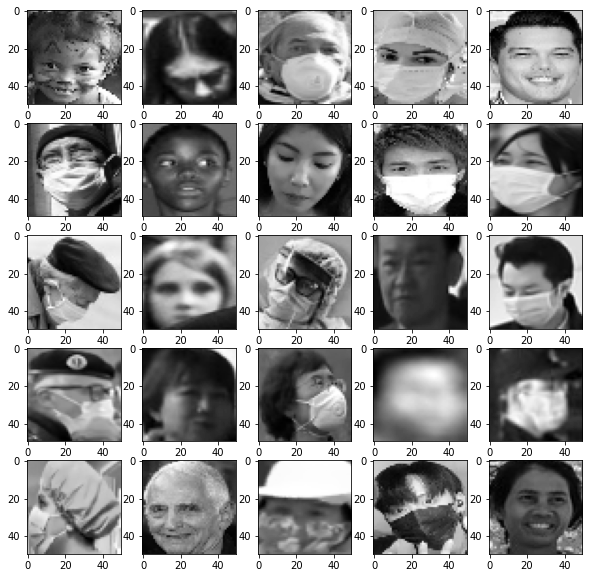

In [ ]:
#@title 7. Ejemplo imagenes prepocesadas
#@markdown Algunas imagenes prepocesadas que se usarán para el entrenamiento y el test.
fig = plt.figure(figsize=(10,10))

for i in range(25):
  ax=fig.add_subplot(5,5,i+1)
  plt.imshow(datos[np.random.randint(len(datos))][1],cmap='gray')

In [ ]:
#@title 8. Creación X y Y para train y test
#@markdown Se crean los vectores X y Y que se usarán para el entrenamiento a partir de los datos extraidos de la función create_data. Esto vectores se crearán así:

#@markdown - En X se almacenarán los arreglos de las imagenes productos del reshape.
#@markdown - En Y se almacenarán las clases de las imagenes para esto se aplica un LabelEncoder para tener las clases en terminos de 0 y 1
x=[]
y=[]
xMatriz=[]
for imag, matriz,etiqueta, ruta in datos:
    x.append(imag)
    xMatriz.append(matriz)
    y.append(etiqueta)

#Vuelve las clases 0 o 1
lbl=LabelEncoder()
y=lbl.fit_transform(y)

#Normaliza los datos
#x=tf.keras.utils.normalize(x,axis=1)
print(lbl.classes_)

['face_no_mask' 'face_with_mask']


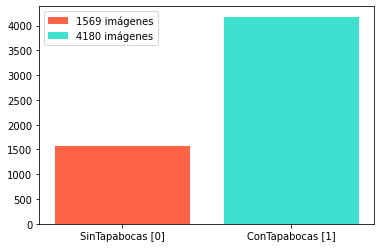

In [ ]:
#@title Número de imagenes de cada clase utilizadas para entramiento y validación de los modelos
plt.bar("SinTapabocas [0]",1569,color='tomato')
plt.bar("ConTapabocas [1]",4180,color='turquoise')

plt.legend(["1569 imágenes","4180 imágenes"])
plt.show()

# Entrenamiento

## Machine Learning
- SVC
- DecisionTreeClassifier
- RandomForestClassifier
- GaussianNB

In [ ]:
#@title Función para la variación de los Kfold
def cross_variacion(est,x,y):
    means, stds = [], []
    nfolds_range = range(2,10)
    for nfolds in nfolds_range:
        #print (nfolds,)
        s = cross_val_score(est, x, y, cv=KFold(nfolds, shuffle=True), scoring=make_scorer(mean_squared_error))
        means.append(np.mean(s))
        stds.append(np.std(s))

    means = np.r_[means]
    stds  = np.r_[stds]

    return nfolds_range, means, stds

In [ ]:
#@title Función para pintar la media y desviación estandar de cada experimento de Machine Learning
def pinta_datos(nombreImagen,nfolds_range, means, stds):
  plt.plot(nfolds_range, means, label="mean", color="black")
  plt.fill_between(nfolds_range, means-stds, means+stds, color="blue", alpha=.5, label="std")
  plt.xlabel("n folds")
  plt.ylabel("performance")
  plt.title(nombreImagen)
  plt.savefig(nombreImagen)
  plt.legend()

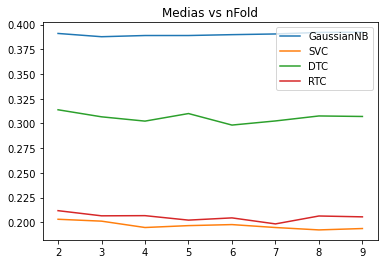

In [ ]:
#@title Experimentos con los modelos 
#@markdown - Modelo SVC
#@markdown - Modelo Gaussian Naive Bayes
#@markdown - Modelo Decision Tree Classifier
#@markdown - Modelo Random Forest Classifier

#@markdown Representación de los valores de la media obtenidos para cada modelo

nfoldSVC, meansSVC, stdsSVC = cross_variacion(SVC(),x,y)
nfoldGNB, meansGNB, stdsGNB = cross_variacion(GaussianNB(),x,y)
nfoldDTC, meansDTC, stdsDTC = cross_variacion(DecisionTreeClassifier(),x,y)
nfoldRTC, meansRTC, stdsRTC = cross_variacion(RandomForestClassifier(),x,y)

plt.plot(np.array(nfoldGNB),meansGNB)
plt.plot(np.array(nfoldSVC),meansSVC)
plt.plot(np.array(nfoldDTC),meansDTC)
plt.plot(np.array(nfoldRTC),meansRTC)
plt.legend(['GaussianNB', 'SVC','DTC','RTC'])
plt.title('Medias vs nFold')
plt.savefig('graficasMedias.png')
plt.show()

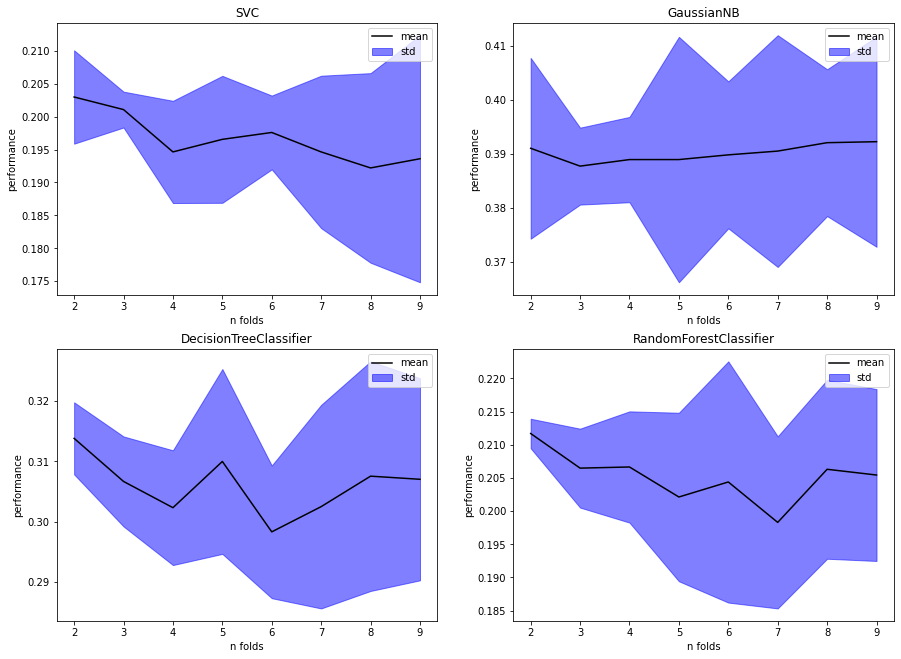

In [ ]:
#@title Una vista del comportamiento de las medias y las desviaciones estandar de los diferentes modelos de machine learning
plt.figure(figsize=(15,11))

plt.subplot(2,2,1)
pinta_datos('SVC',nfold,meansSVC,stdsSVC)

plt.subplot(2,2,2)
pinta_datos('GaussianNB',nfoldGNB,meansGNB,stdsGNB)

plt.subplot(2,2,3)
pinta_datos('DecisionTreeClassifier',nfoldDTC,meansDTC,stdsDTC)

plt.subplot(2,2,4)
pinta_datos('RandomForestClassifier',nfoldRTC,meansRTC,stdsRTC)

plt.show()

## DNN

In [ ]:
#@title Datos para los modelos DNN
#@markdown Para el entramiento de los modelos se toman 80% de los datos y para validación el 20% restante de los datos

xMatrizNP=np.array(xMatriz)
xDNN=xMatrizNP.reshape([-1,50,50,1])

X_trainDNN, X_testDNN, y_trainDNN, y_testDNN = train_test_split(xDNN,y,test_size=0.2)
print("train_test_split:",X_trainDNN.shape, y_trainDNN.shape, X_testDNN.shape, y_testDNN.shape)

y_train_ohe = tf.keras.utils.to_categorical(y_trainDNN, num_classes=2)
y_test_ohe = tf.keras.utils.to_categorical(y_testDNN, num_classes=2)
print("ohe:",y_train_ohe.shape, y_test_ohe.shape)

train_test_split: (4599, 50, 50, 1) (4599,) (1150, 50, 50, 1) (1150,)
ohe: (4599, 2) (1150, 2)


### Experimentación

Para entrenamiento de todos los modelos se usa:
- optimizer: SGD(learningRate=0.001)
- Loss: binary_crossentropy
- Metrics: binary_accuracy
- epochs: 20
- bastch_size: 16

#### Modelos

In [ ]:
#@title Modelo 1.
#@markdown Modelo DNN con la sigiuente arquitectura:
#@markdown - Capa Inicial: Todos los datos
#@markdown - Capa Oculta 1: 2048 neuronas y función de activación sigmoid
#@markdown - Capa Oculta 2: 1024 neuronas y función de activación relu
#@markdown - Capa Oculta 3: 512 neuronas y función de activación relu
#@markdown - Capa Oculta 4: 256 neuronas y función de activación relu
#@markdown - Capa Oculta 5: 128 neuronas y función de activación relu
#@markdown - Capa Final: 2 neuronas y funcióón de activacióón softmax

modelDNN1 = tf.keras.Sequential([
    tf.keras.layers.Flatten( input_shape=[50,50,1]),
    tf.keras.layers.Dense(2048, activation=tf.nn.sigmoid),
    tf.keras.layers.Dense(1024, activation=tf.nn.relu),
    tf.keras.layers.Dense(512, activation=tf.nn.relu),
    tf.keras.layers.Dense(256, activation=tf.nn.relu),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(2, activation=tf.nn.softmax)
])

modelDNN1.summary()

opt = SGD(lr=0.001)#, momentum=0.9, decay=0.01)
modelDNN1.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['binary_accuracy'])

history = modelDNN1.fit(X_trainDNN,
          y_train_ohe,
          epochs=20,
          batch_size=16,
          validation_data=(X_testDNN, y_test_ohe))

modelDNN1.save('modelos/modelo1.h5')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 2500)              0         
_________________________________________________________________
dense (Dense)                (None, 2048)              5122048   
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 2

In [ ]:
#@title Modelo 2.
#@markdown Modelo DNN con la sigiuente arquitectura:
#@markdown - Capa Inicial: Todos los datos
#@markdown - Capa Oculta 1: 2048 neuronas y función de activación sigmoid
#@markdown - Capa Oculta 2: 1024 neuronas y función de activación tanh
#@markdown - Capa Oculta 3: 512 neuronas y función de activación tanh
#@markdown - Capa Oculta 4: 256 neuronas y función de activación tanh
#@markdown - Capa Oculta 5: 128 neuronas y función de activación tanh
#@markdown - Capa Final: 2 neuronas y funcióón de activacióón softmax

modelDNN2 = tf.keras.Sequential([
    tf.keras.layers.Flatten( input_shape=[50,50,1]),
    tf.keras.layers.Dense(2048, activation=tf.nn.sigmoid),
    tf.keras.layers.Dense(1024, activation=tf.nn.tanh),
    tf.keras.layers.Dense(512, activation=tf.nn.tanh),
    tf.keras.layers.Dense(256, activation=tf.nn.tanh),
    tf.keras.layers.Dense(128, activation=tf.nn.tanh),
    tf.keras.layers.Dense(2, activation=tf.nn.softmax)
])

modelDNN2.summary()

opt = SGD(lr=0.001)#, momentum=0.9, decay=0.01)
modelDNN2.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['binary_accuracy'])

history = modelDNN2.fit(X_trainDNN,
          y_train_ohe,
          epochs=20,
          batch_size=16,
          validation_data=(X_testDNN, y_test_ohe))

modelDNN2.save('modelos/modelo2.h5')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 2500)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 2048)              5122048   
_________________________________________________________________
dense_7 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dense_8 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_9 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_10 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_11 (Dense)             (None, 2)                

In [ ]:
#@title Modelo 3.
#@markdown Modelo DNN con la sigiuente arquitectura:
#@markdown - Capa Inicial: Todos los datos
#@markdown - Capa Oculta 1: 512 neuronas y función de activación sigmoid
#@markdown - Capa Oculta 2: 256 neuronas y función de activación relu
#@markdown - Capa Oculta 3: 128 neuronas y función de activación relu
#@markdown - Capa Final: 2 neuronas y funcióón de activacióón softmax
modelDNN3 = tf.keras.Sequential([
    tf.keras.layers.Flatten( input_shape=[50,50,1]),
    tf.keras.layers.Dense(512, activation=tf.nn.sigmoid),
    tf.keras.layers.Dense(256, activation=tf.nn.relu),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(2, activation=tf.nn.softmax)
])

modelDNN3.summary()

#learning_rate=0.01
#
opt = SGD(lr=0.001, momentum=0.9, decay=0.01)
modelDNN3.compile(optimizer=opt,
              loss='binary_crossentropy',#'sparse_categorical_crossentropy',
              metrics=['binary_accuracy'])

history = modelDNN3.fit(X_trainDNN,
          y_train_ohe,
          epochs=20,
          batch_size=16,
          validation_data=(X_testDNN, y_test_ohe))

modelDNN3.save('modelos/modelo3.h5')

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 2500)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 512)               1280512   
_________________________________________________________________
dense_13 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_14 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_15 (Dense)             (None, 2)                 258       
Total params: 1,444,994
Trainable params: 1,444,994
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
288/288 [==============================] - 1s 4ms/step - loss: 0.5913 - binary_accuracy: 0.7215 - v

#### Resultados y evaluación

Accuracy (0.7260869741439819, 0.7573913335800171, 0.7513043284416199)
Loss (0.5434809923171997, 0.5183190107345581, 0.5084686279296875)


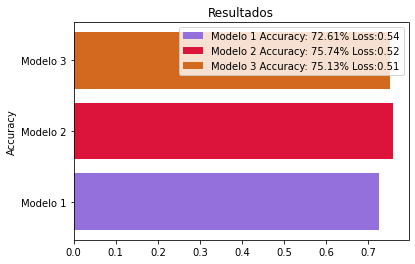

In [ ]:
#@title Graficos de resultados accuracy para los 3 modelos
#@markdown - Accuracy
#@markdown - Loss
test_loss1, test_acc1 = modelDNN1.evaluate(X_testDNN, y_test_ohe, verbose=False)
test_loss2, test_acc2 = modelDNN2.evaluate(X_testDNN, y_test_ohe, verbose=False)
test_loss3, test_acc3 = modelDNN3.evaluate(X_testDNN, y_test_ohe, verbose=False)


test_acc=(test_acc1,test_acc2,test_acc3)
print("Accuracy",test_acc)
test_loss=(test_loss1,test_loss2,test_loss3)
print("Loss",test_loss)

plt.barh("Modelo 1",test_acc[0],color='mediumpurple')
plt.barh("Modelo 2",test_acc[1],color='crimson')
plt.barh("Modelo 3",test_acc[2],color='chocolate')
stra1="%.2f" % (test_acc[0]*100)+ "%"
stra2="%.2f" % (test_acc[1]*100)+ "%"
stra3="%.2f" % (test_acc[2]*100)+ "%"
strl1="%.2f" % test_loss[0]
strl2="%.2f" % test_loss[1]
strl3="%.2f" % test_loss[2]
plt.legend(["Modelo 1 Accuracy: "+stra1+" Loss:"+strl1,
            "Modelo 2 Accuracy: "+stra2+" Loss:"+strl2,
            "Modelo 3 Accuracy: "+stra3+" Loss:"+strl3])
plt.title('Resultados')
plt.ylabel('Accuracy')
plt.show()

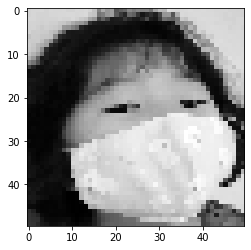

In [ ]:
#@title Imagen para predecir
imagenMostrar=np.random.randint(1150)
plt.imshow(np.squeeze(X_testDNN[imagenMostrar]),cmap='gray')

prueba=np.expand_dims(X_testDNN[imagenMostrar],axis=0)

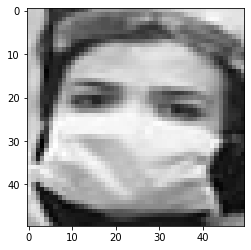

In [ ]:
#@title Imagen para predecir 2
imagenMostrar=np.random.randint(1150)
plt.imshow(np.squeeze(X_testDNN[imagenMostrar]),cmap='gray')

prueba2=np.expand_dims(X_testDNN[imagenMostrar],axis=0)

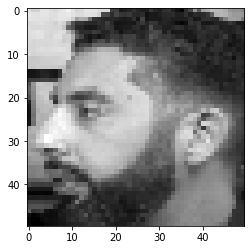

In [ ]:
#@title Imagen para predecir 3
imagenMostrar=np.random.randint(1150)
plt.imshow(np.squeeze(X_testDNN[imagenMostrar]),cmap='gray')

prueba3=np.expand_dims(X_testDNN[imagenMostrar],axis=0)

ValueError: ignored

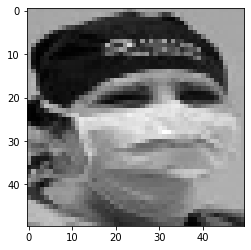

In [ ]:
#@title Imagen para predecir 4
imagenMostrar=np.random.randint(1150)
plt.imshow(np.squeeze(X_testDNN[imagenMostrar]),cmap='gray')

prueba4=np.expand_dims(X_testDNN[imagenMostrar],axis=0)

In [ ]:
#@title Predicción de los modelos
prediccion11=modelDNN1.predict(prueba)
prediccion21=modelDNN2.predict(prueba)
prediccion31=modelDNN3.predict(prueba)
prediccion12=modelDNN1.predict(prueba2)
prediccion22=modelDNN2.predict(prueba2)
prediccion32=modelDNN3.predict(prueba2)
prediccion13=modelDNN1.predict(prueba3)
prediccion23=modelDNN2.predict(prueba3)
prediccion33=modelDNN3.predict(prueba3)
prediccion14=modelDNN1.predict(prueba4)
prediccion24=modelDNN2.predict(prueba4)
prediccion34=modelDNN3.predict(prueba4)

predicciones=[prediccion11,prediccion21,prediccion31,prediccion12,prediccion22,prediccion32,prediccion13,prediccion23,prediccion33,prediccion14,prediccion24,prediccion34]
for i in range(len(predicciones)):
  #claseCero.append(predicciones[i][0])
  #claseUno.append(predicciones[i][1])
  print("Modelo",(i%3)+1,":",predicciones[i])

Modelo 1 : [[0.2928089 0.7071911]]
Modelo 2 : [[0.2216483 0.7783517]]
Modelo 3 : [[0.23267612 0.7673239 ]]
Modelo 1 : [[0.29434755 0.7056524 ]]
Modelo 2 : [[0.25293052 0.7470695 ]]
Modelo 3 : [[0.19821873 0.80178124]]
Modelo 1 : [[0.6020193 0.3979807]]
Modelo 2 : [[0.4757239 0.5242761]]
Modelo 3 : [[0.42030725 0.5796928 ]]
Modelo 1 : [[0.83821833 0.16178171]]
Modelo 2 : [[0.7949441  0.20505589]]
Modelo 3 : [[0.39750442 0.60249555]]


In [ ]:
predicion=[(0.2928089,0.7071911),(0.2216483,0.7783517),(0.23267612,0.7673239),(0.29434755,0.7056524),(0.25293052,0.7470695),(0.19821873,0.80178124),(0.6020193,0.3979807),(0.4757239,0.5242761),(0.42030725,0.5796928),(0.83821833,0.16178171),(0.7949441,0.20505589),(0.39750442,0.60249555)]

for i in range(len(predicion)):
  print("Modelo",(i%3)+1,":",predicion[i])

Modelo 1 : (0.2928089, 0.7071911)
Modelo 2 : (0.2216483, 0.7783517)
Modelo 3 : (0.23267612, 0.7673239)
Modelo 1 : (0.29434755, 0.7056524)
Modelo 2 : (0.25293052, 0.7470695)
Modelo 3 : (0.19821873, 0.80178124)
Modelo 1 : (0.6020193, 0.3979807)
Modelo 2 : (0.4757239, 0.5242761)
Modelo 3 : (0.42030725, 0.5796928)
Modelo 1 : (0.83821833, 0.16178171)
Modelo 2 : (0.7949441, 0.20505589)
Modelo 3 : (0.39750442, 0.60249555)


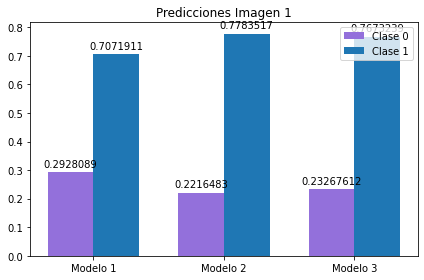

In [ ]:
#@title Grafica Imagen Prediccion1
ind=np.arange(3)
listaModelos=["Modelo 1","Modelo 2","Modelo 3"]
datosCeros=[predicion[0][0],predicion[1][0],predicion[2][0]]
datosUnos=[predicion[0][1],predicion[1][1],predicion[2][1]]

x=np.arange(len(listaModelos))
width=0.35

fig,ax=plt.subplots()
rects1 = ax.bar(x - width/2, datosCeros, width, label='Clase 0',color='mediumpurple')
rects2 = ax.bar(x + width/2, datosUnos, width, label='Clase 1')

ax.set_title('Predicciones Imagen 1')
ax.set_xticks(x)
ax.set_xticklabels(listaModelos)
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

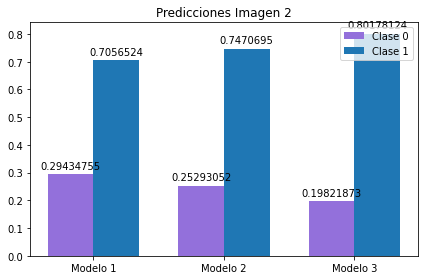

In [ ]:
#@title Grafica Imagen Prediccion2
ind=np.arange(3)
listaModelos=["Modelo 1","Modelo 2","Modelo 3"]
datosCeros=[predicion[3][0],predicion[4][0],predicion[5][0]]
datosUnos=[predicion[3][1],predicion[4][1],predicion[5][1]]

x=np.arange(len(listaModelos))
width=0.35

fig,ax=plt.subplots()
rects1 = ax.bar(x - width/2, datosCeros, width, label='Clase 0',color='mediumpurple')
rects2 = ax.bar(x + width/2, datosUnos, width, label='Clase 1')

ax.set_title('Predicciones Imagen 2')
ax.set_xticks(x)
ax.set_xticklabels(listaModelos)
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

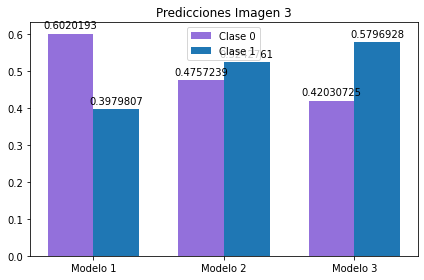

In [ ]:
#@title Grafica Imagen Prediccion3
ind=np.arange(3)
listaModelos=["Modelo 1","Modelo 2","Modelo 3"]
datosCeros=[predicion[6][0],predicion[7][0],predicion[8][0]]
datosUnos=[predicion[6][1],predicion[7][1],predicion[8][1]]

x=np.arange(len(listaModelos))
width=0.35

fig,ax=plt.subplots()
rects1 = ax.bar(x - width/2, datosCeros, width, label='Clase 0',color='mediumpurple')
rects2 = ax.bar(x + width/2, datosUnos, width, label='Clase 1')

ax.set_title('Predicciones Imagen 3')
ax.set_xticks(x)
ax.set_xticklabels(listaModelos)
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

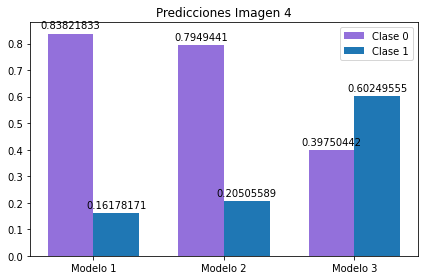

In [ ]:
#@title Grafica Imagen Prediccion4
ind=np.arange(3)
listaModelos=["Modelo 1","Modelo 2","Modelo 3"]
datosCeros=[predicion[9][0],predicion[10][0],predicion[11][0]]
datosUnos=[predicion[9][1],predicion[10][1],predicion[11][1]]

x=np.arange(len(listaModelos))
width=0.35

fig,ax=plt.subplots()
rects1 = ax.bar(x - width/2, datosCeros, width, label='Clase 0',color='mediumpurple')
rects2 = ax.bar(x + width/2, datosUnos, width, label='Clase 1')

ax.set_title('Predicciones Imagen 4')
ax.set_xticks(x)
ax.set_xticklabels(listaModelos)
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

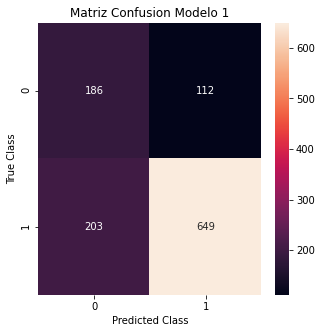

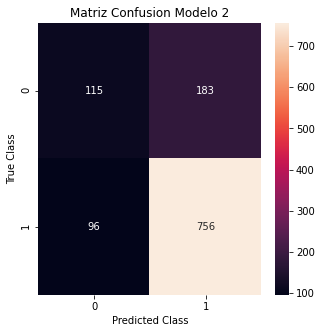

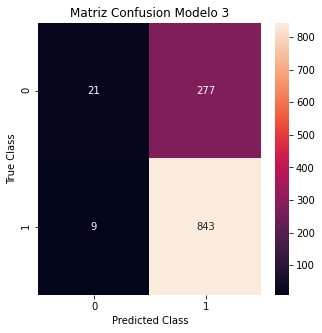

In [ ]:
#@title Matriz de confusión modelos
def pintaMatrizConfusion (modeloFun,y_test,x_test,modeloTitle):
  #Forma 1 para el y predicho
  y_estimated = modeloFun.predict_classes(x_test)
  #Forma 2 para el y predicho
  #pred_y = np.argmax(modeloFun.predict(x_test), axis=-1)
  conf_matrix= confusion_matrix(y_test,y_estimated)
  plt.figure(figsize=(5, 5))
  sns.heatmap(conf_matrix,  annot=True, fmt="d");
  plt.title(modeloTitle)
  plt.ylabel('True Class')
  plt.xlabel('Predicted Class')
  plt.show()

pintaMatrizConfusion(modelDNN1,y_testDNN,X_testDNN,"Matriz Confusion Modelo 1")
pintaMatrizConfusion(modelDNN2,y_testDNN,X_testDNN,"Matriz Confusion Modelo 2")
pintaMatrizConfusion(modelDNN3,y_testDNN,X_testDNN,"Matriz Confusion Modelo 3")